In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import socceraction.spadl as spadl
import os

Concatenate actions of all games in one DataFrame.

In [82]:
datafolder = "data"
fifa2018h5 = os.path.join(datafolder, "spadl-fifa2018.h5")
games = pd.read_hdf(fifa2018h5, key="games")
with pd.HDFStore(fifa2018h5) as store:
    actions = [] #list of DataFrames
    for game in tqdm.tqdm(games.itertuples()):
        game_action = store[f"actions/game_{game.game_id}"]
        game_action = spadl.play_left_to_right(game_action, game.home_team_id)
        game_action["is_home"] = game_action["team_id"] == game.home_team_id
        actions.append(game_action)
    actions = pd.concat(actions)
    actions.drop("original_event_id", axis=1, inplace=True )
    actions = pd.merge(actions, spadl.config.actiontypes_df(), how="left")

64it [00:00, 182.19it/s]


In [83]:
def consolidate(actions):
    #actions.fillna(0, inplace=True)

    #Consolidate corner_short and corner_crossed
    corner_idx = actions.type_name.str.contains("corner")
    actions["type_name"] = actions["type_name"].mask(corner_idx,"corner")

    #Consolidate freekick_short, freekick_crossed, and shot_freekick
    freekick_idx = actions.type_name.str.contains("freekick")
    actions["type_name"] = actions["type_name"].mask(freekick_idx,"freekick")

    #Consolidate keeper_claim, keeper_punch, keeper_save, keeper_pick_up
    keeper_idx = actions.type_name.str.contains("keeper")
    actions["type_name"] = actions["type_name"].mask(keeper_idx,"keeper_action")

    actions["start_x"] = actions["start_x"].mask(actions.type_name=="shot_penalty",94.5)
    actions["start_y"] = actions["start_y"].mask(actions.type_name=="shot_penalty",34)

    return actions

actions = consolidate(actions)

In [84]:
#Actions of Team France matches.
len(actions[actions["team_id"] == 771])

6829

In [85]:
actions.groupby("type_name").size()

type_name
bad_touch         1547
clearance         2074
corner             558
cross             1305
dribble          52731
foul              1876
freekick          1272
goalkick           677
interception      1681
keeper_action      584
pass             56438
shot              1556
shot_penalty        68
tackle            1830
take_on           2109
throw_in          2178
dtype: int64

As suggested in SoccerMix, add noise on the starting and ending locations, but only on those actions that we can visually note a predefined pattern.
* *Add noise in both start and end locations*:
    * Cross
    * Shot
    * Keeper_action
* *Only on start locations*:
    * Clearance
    * Goal kick
* *Only on end locations*:
    * Corner
    * Freekick
    * Shot_penalty

In [86]:
def add_noise(actions):
    # Start locations
    start_list = ["cross", "shot", "keeper_action", "clearance", "goalkick"]
    mask = actions["type_name"].isin(start_list)
    noise = np.random.normal(0, 0.5, size=actions.loc[mask, ["start_x", "start_y"]].shape)
    actions.loc[mask, ["start_x", "start_y"]] += noise

    # End locations
    end_list = ["cross", "shot", "keeper_action", "corner", "freekick", "shot_penalty"]
    mask = actions["type_name"].isin(end_list)
    noise = np.random.normal(0,0.5, size=actions.loc[mask, ["end_x", "end_y"]].shape)
    actions.loc[mask, ["end_x", "end_y"]] += noise

    return actions

actions = add_noise(actions)

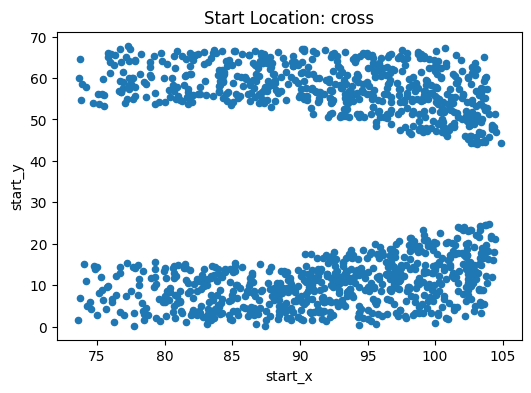

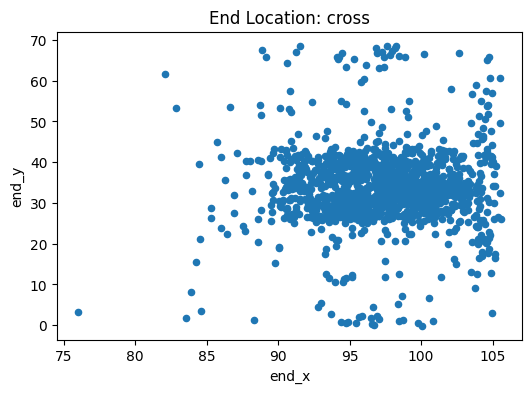

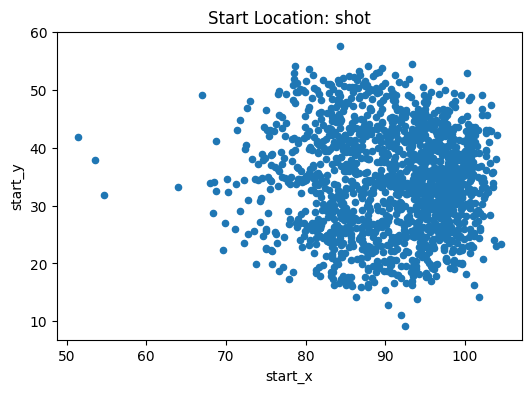

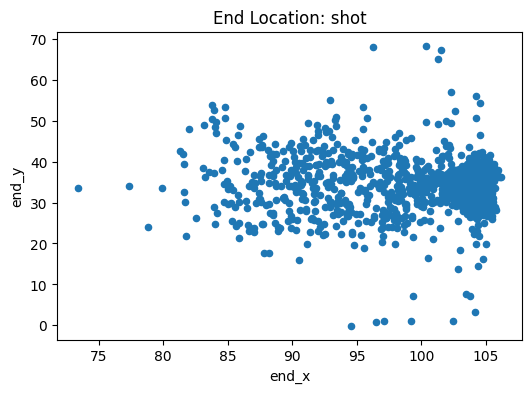

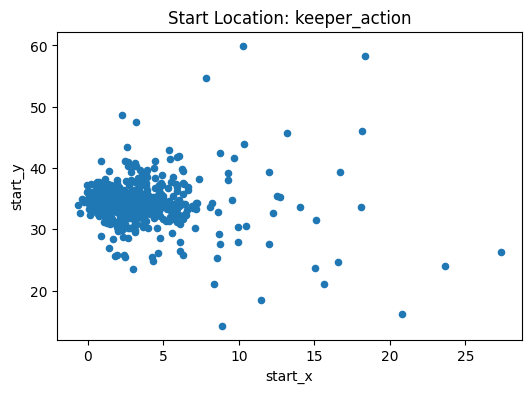

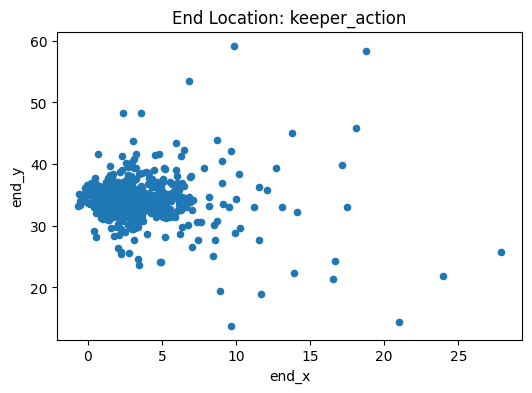

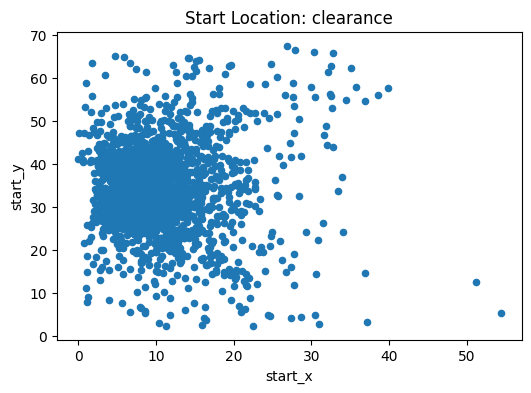

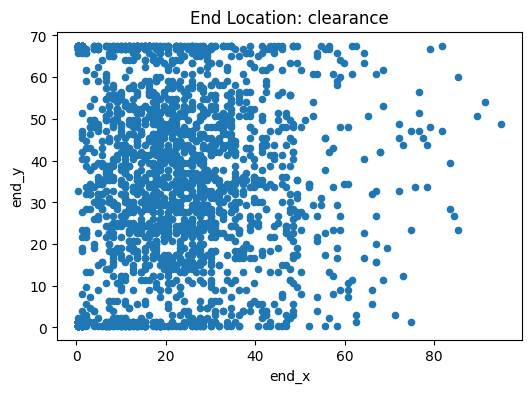

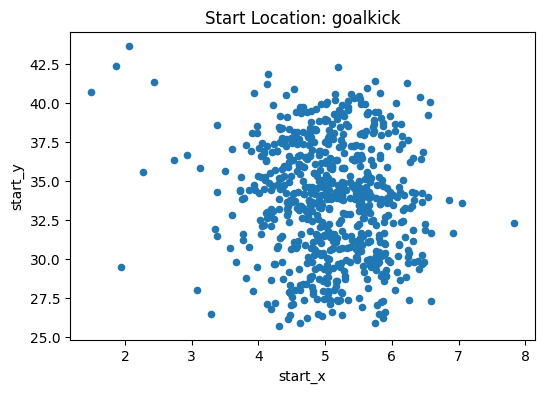

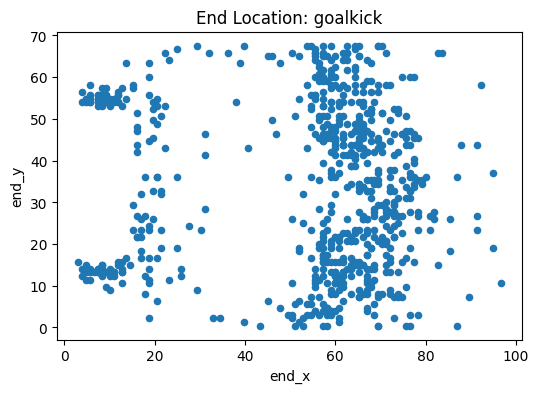

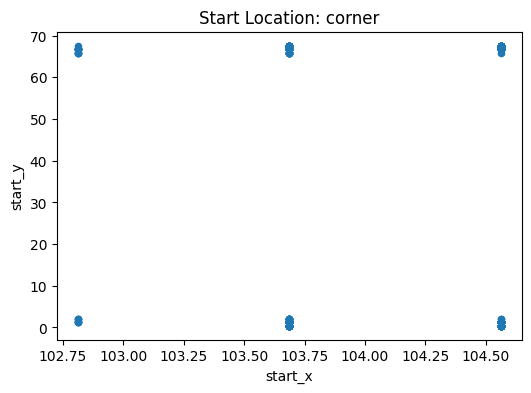

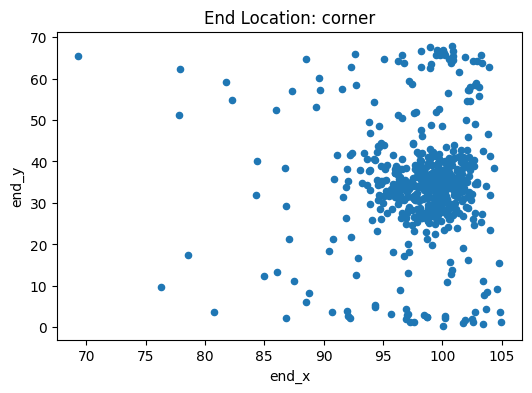

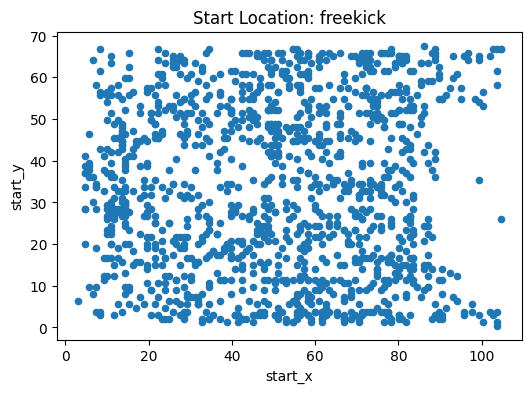

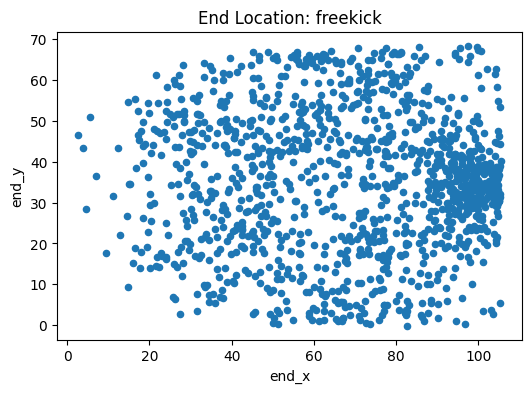

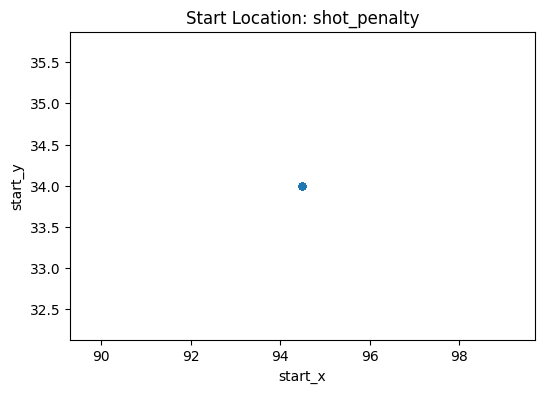

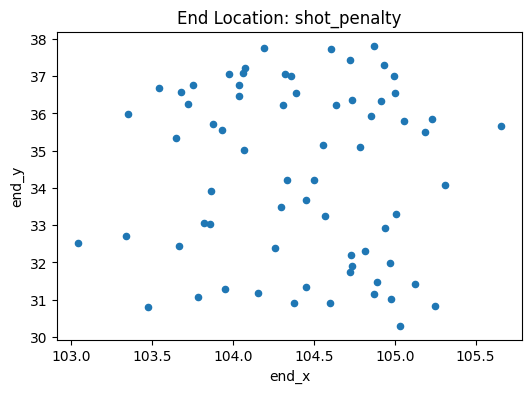

In [87]:
corrected_actions = ["cross", "shot", "keeper_action", "clearance", "goalkick","corner", "freekick", "shot_penalty"]
for actiontype in corrected_actions:
    actions[actions.type_name == actiontype].plot.scatter(
        x="start_x",
        y="start_y",
        title = f"Start Location: {actiontype}",
        figsize = (6,4)
    )
    plt.show()
    actions[actions.type_name == actiontype].plot.scatter(
        x="end_x",
        y="end_y",
        title = f"End Location: {actiontype}",
        figsize = (6,4)
    )
    plt.show()